In [1]:
# data manipulation:
import pandas as pd
import numpy as np

# stats:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
from scipy import stats
import math

# plotting and images:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

---
## About the Data:
In this chapter we explore the metrics by which the success of stocks and funds are measured. We saw some of these back in chapter 8 (Beta). In what follows below, we look at the tremendous success of the Rennaissance Medallion fund. 

We obtain the "Sortino" ratio, as well as the "Alpha" of the fund and we check the value of the metrics against in the context of the market forces that drive returns of investment.

#### About Jim Simmons:
The Medallion fund was founded by MIT Mathematician Jim Simmons, who after an illustrious carreer breaking codes for the US government, set out to solve the world's hardest problem: the stok market. 

book: https://www.goodreads.com/book/show/43889703-the-man-who-solved-the-market?ac=1&from_search=true&qid=k9slcBQgJt&rank=1

numberphile video: https://www.youtube.com/watch?v=gjVDqfUhXOY

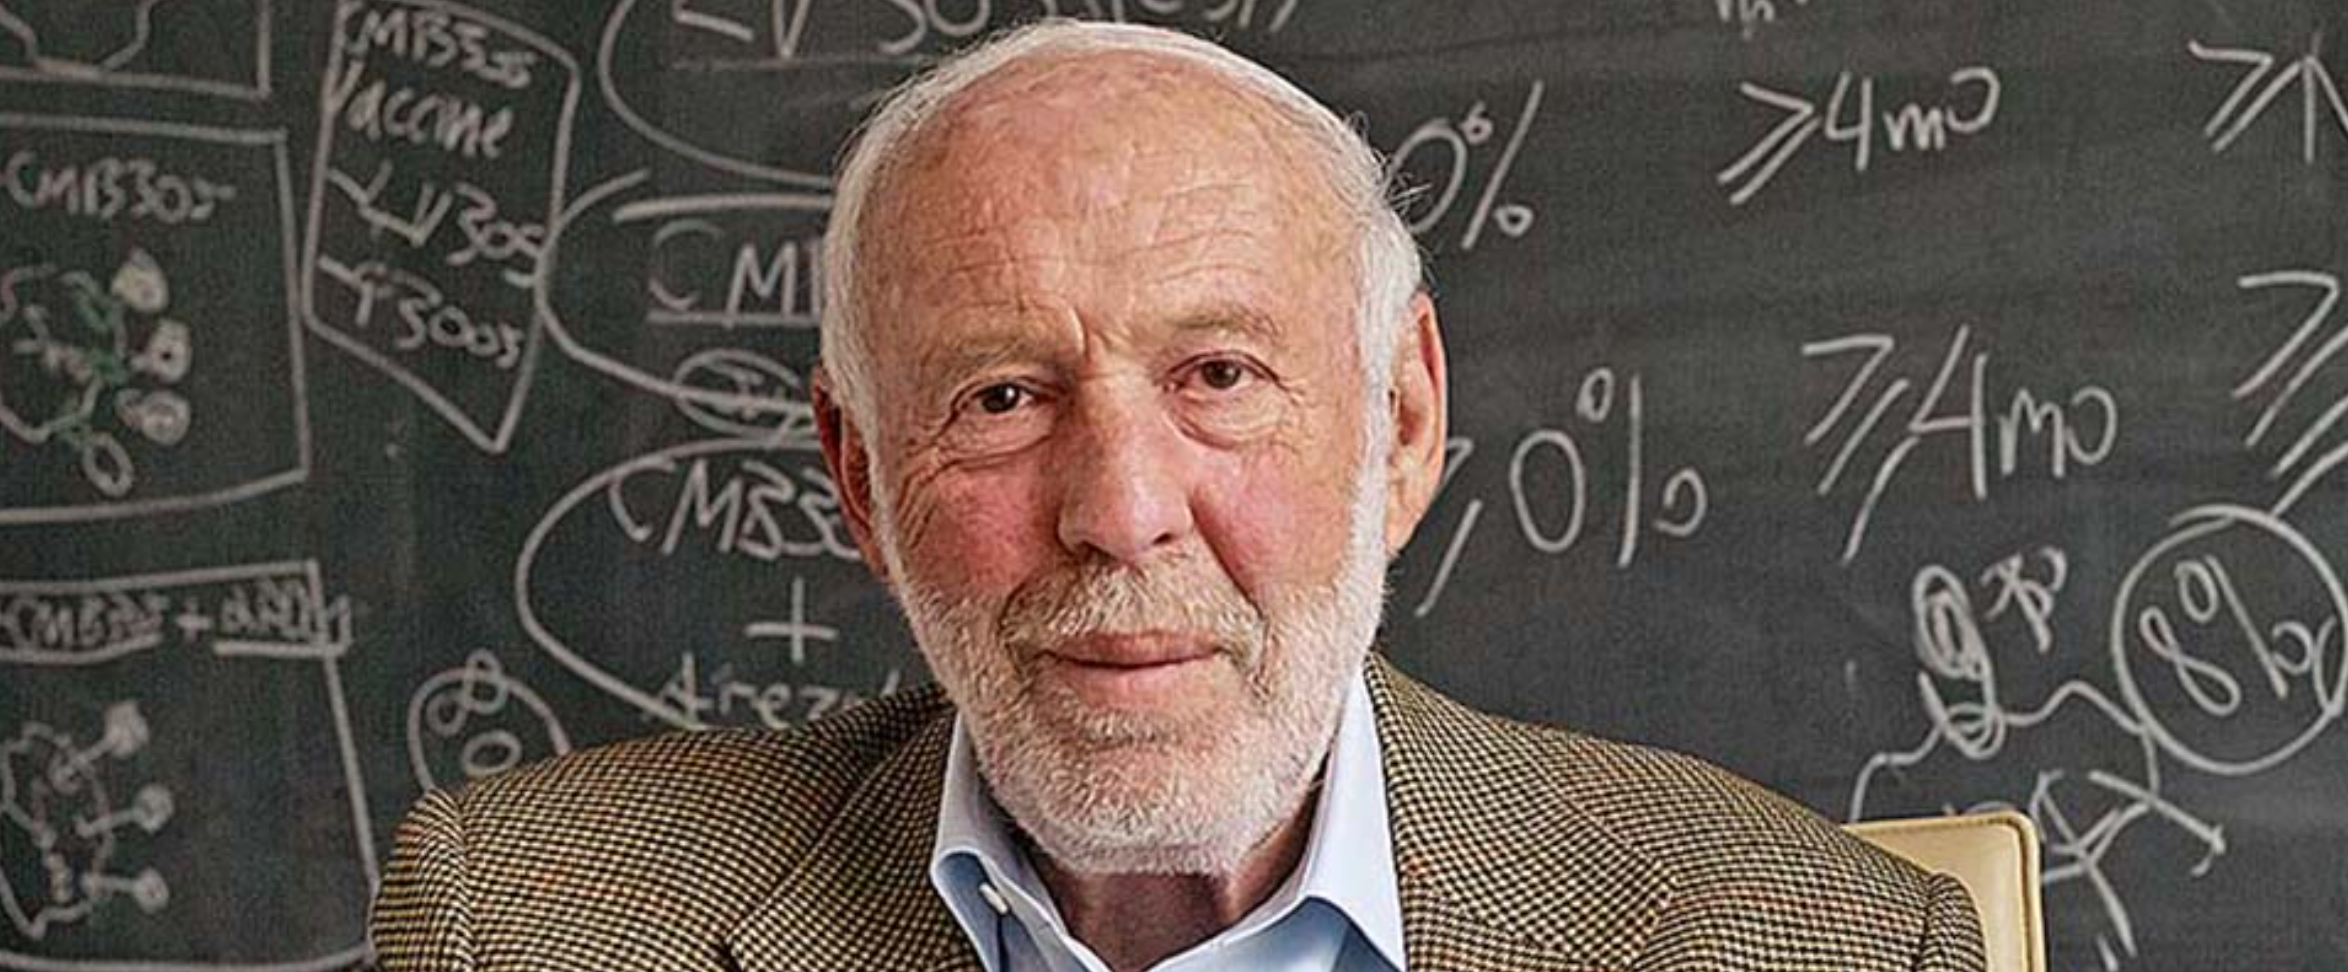

In [2]:
Image(filename='./images/jim_simmons.png', width=1000) 

---
### Import the dataset:

In [3]:
medallion_df = pd.read_excel("Chapter22.xlsx", sheet_name='Renaissance', header=1).iloc[0:29, 3:7]
medallion_df.head(10)

Year  REN Return  Stocks  T Bills
0  1990.0       0.560 -0.0306   0.0624
1  1991.0       0.394  0.3023   0.1500
2  1992.0       0.340  0.0749   0.0936
3  1993.0       0.391  0.0997   0.1421
4  1994.0       0.701  0.0133  -0.0804
5  1995.0       0.383  0.3720   0.2348
6  1996.0       0.315  0.2268   0.0143
7  1997.0       0.212  0.3310   0.0994
8  1998.0       0.415  0.2834   0.1492
9  1999.0       0.245  0.2089  -0.0825

---
## Plot returns:

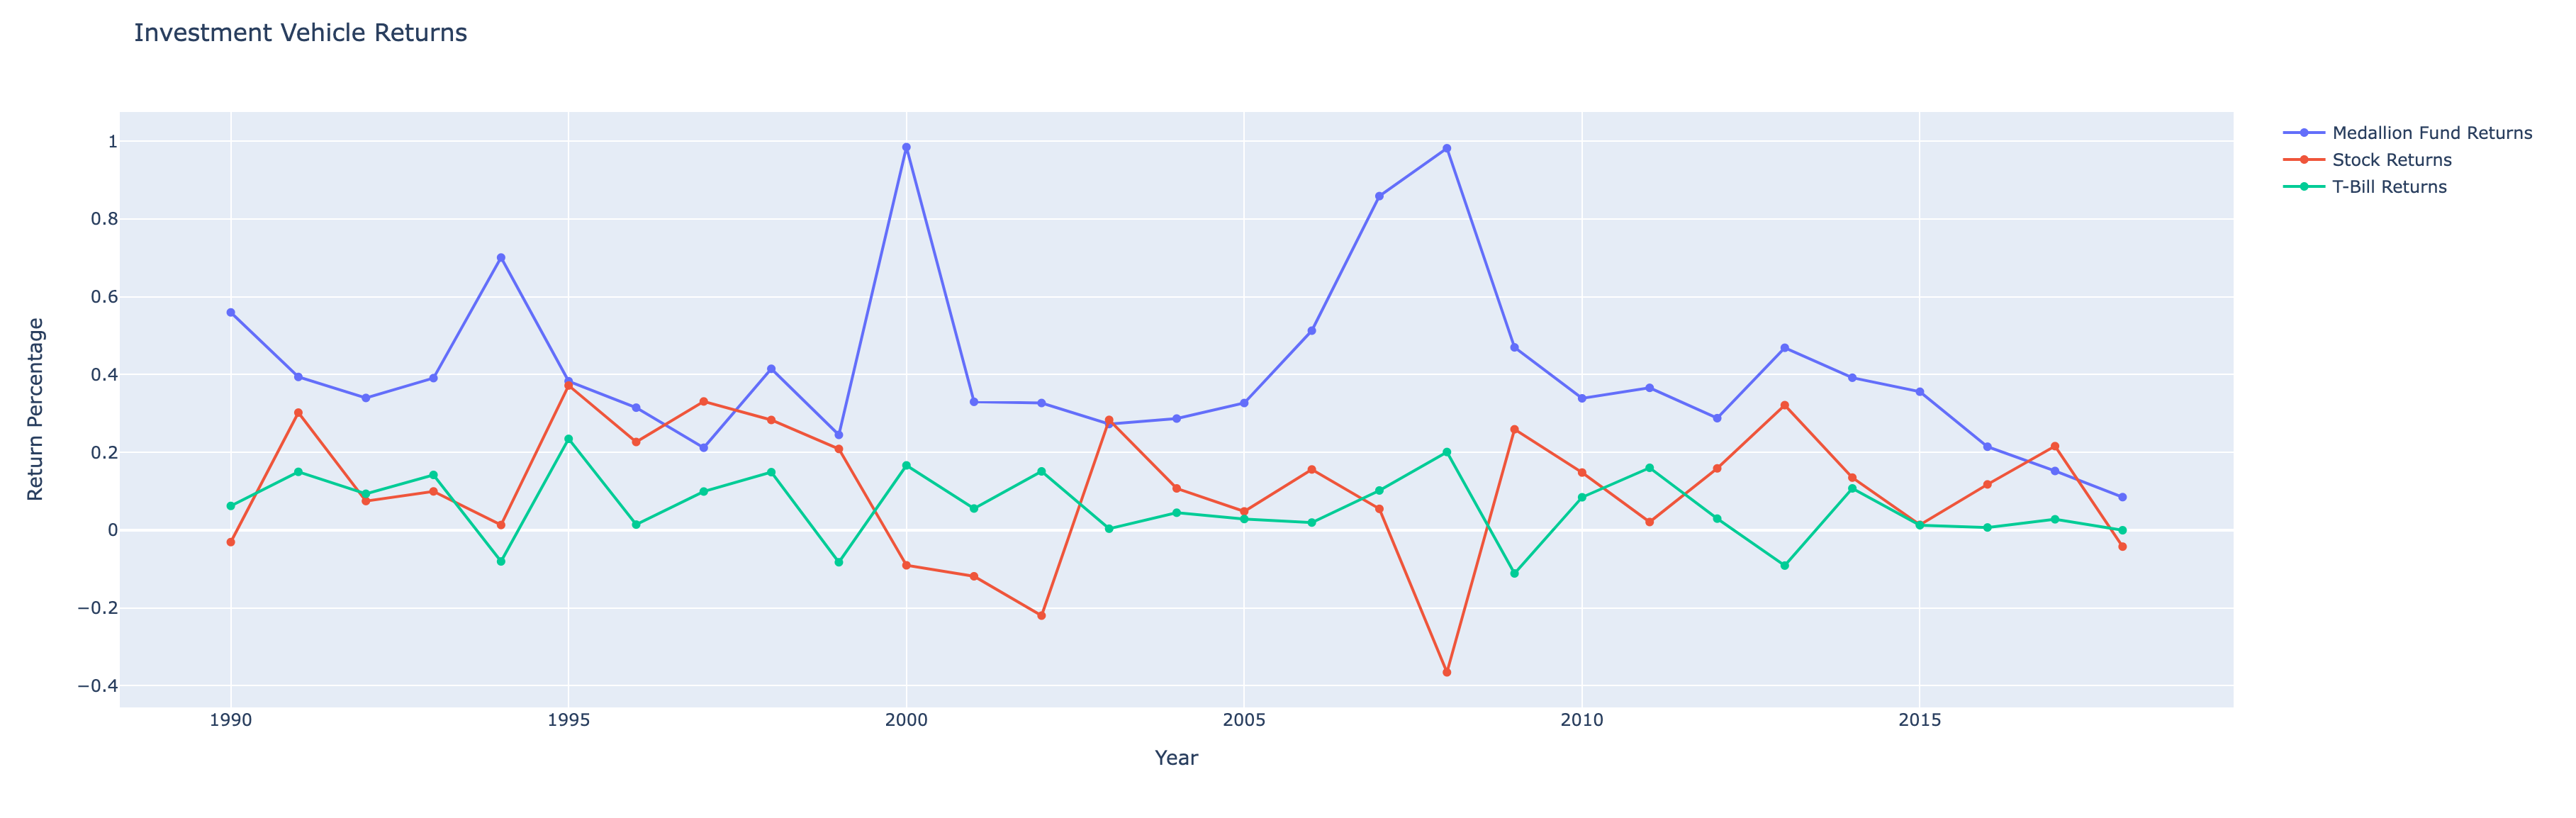

In [4]:
# returns for all three vehicles:
returns_fig = go.Figure()
returns_fig.add_trace(go.Scatter(x=medallion_df['Year'], y=medallion_df['REN Return'],  mode='lines+markers', name='Medallion Fund Returns'))
returns_fig.add_trace(go.Scatter(x=medallion_df['Year'], y=medallion_df['Stocks'],  mode='lines+markers', name='Stock Returns'))
returns_fig.add_trace(go.Scatter(x=medallion_df['Year'], y=medallion_df['T Bills'],  mode='lines+markers', name='T-Bill Returns'))
returns_fig.update_layout(
        height=600,
        width=1800,
        title_text='Investment Vehicle Returns',
        xaxis_title='Year',
        yaxis_title='Return Percentage'
    )
returns_fig
Image(filename='./images/returns.png', width=1700) 

---
### Calculate the Sortino Ratio:

The Sortino Ratio is given by:
$$ S = \frac{\text{Average Annual Return - Target Annual Return}}{\text{Average Downside Risk}}$$

where:
    $$
    \text{Target Annual Return} = 0.20
    $$
    
and :
  $$
  \text{Average Downside Risk} =
  \begin{cases}
                                   0 & \text{, if Average Annual Returns meet or exceed the Target Annual Return} \\
                                   |\text{Target Annual Return - Average Annual Returns}| & \text{, otherwise}
  \end{cases}
   $$



#### Define the Sortino function and calculate:

In [5]:
# function:
def sortino_ratio(target_fund, target_return):
    avg_annual_return = target_fund.mean()
    ave_downside_risk = np.where((target_fund - target_return) > 0, 0,
                                target_fund - target_return).mean()
    ave_downside_risk = abs(ave_downside_risk)
    sortino = (avg_annual_return - target_return)/(ave_downside_risk)
    
    return sortino

In [6]:
# calculate:
medallion_sortino = sortino_ratio(medallion_df['REN Return'], target_return=0.20)
medallion_sortino

37.90417690417692

**Note:** larger Sortino Ratios are "better".

---
### Calculate the Beta of the fund:
As we have seen back in the chapter 8 notebook, the Beta ($\beta$) of a stock/fund is simple the slope of the line-of-best-fit between the average yearly returns for the fund and an index (such as the S&P 500).

#### Define the Beta function and calculate:

In [7]:
# function:
def fund_beta(df, fund_series, index_series):
    # set linear formula:
    fit_formula = 'Q' + '("' + fund_series + '")' +  "~" + index_series
    
    # fit the formula:
    model = smf.ols(formula=fit_formula, data=df).fit()
    
    # R-squared:
    r_sqrd = round(model.rsquared, 2)
    
    # extract the beta:
    beta = round(model.params.loc[index_series], 2)
    
    return beta, r_sqrd

In [8]:
# calculate:
medallion_beta, medallion_rsquared = fund_beta(medallion_df, fund_series='REN Return', index_series='Stocks')
medallion_beta

-0.56

In [9]:
medallion_rsquared

0.19

**Note:** since the Beta of a stock measures the stock's sensitivity to market movements, the negative Beta for the medallion fund can be explained away on the basis that Medallion is a "Hedge Fund" that tries to reduce its sensitivity to market movements.

The fund's R-squared value tell us how much of the fund's return can be explained away by market movements (for which the S&P is a proxy). A higher R-squared would mean that the fund is pretty much tracking the index and not worth paying high management fees.

As we can see for the corresponding values of the Medallion fund, the numbers show that the market has little effect in the performance of the fund, which can be presumable attributed to the its excellent management.

---
### Calculate the Alpha of the fund:

The Alpha value of a stock/fund is essentially the excess average return over the 90-day Treasury Bills after adjusting for the investment's Beta. 

It is given by the intercept of the line that takes the independent variable the (avg. annual return of fund - annual return of 90-day T-Bills), and as the dependent value the (avg. annual return on the stock market - annual return of 90-day T-Bills).

#### Calculate differences and plot:

In [10]:
# avg. return of fund minus t-bills:
medallion_df['excess returns over Tbills'] = medallion_df['REN Return'] - medallion_df['T Bills']

# beta adjusted returns:
medallion_df['adjusted returns over Tbills'] = medallion_df['Stocks'] - medallion_df['T Bills']
medallion_df.head(10)

Year  REN Return  Stocks  T Bills  excess returns over Tbills  \
0  1990.0       0.560 -0.0306   0.0624                      0.4976   
1  1991.0       0.394  0.3023   0.1500                      0.2440   
2  1992.0       0.340  0.0749   0.0936                      0.2464   
3  1993.0       0.391  0.0997   0.1421                      0.2489   
4  1994.0       0.701  0.0133  -0.0804                      0.7814   
5  1995.0       0.383  0.3720   0.2348                      0.1482   
6  1996.0       0.315  0.2268   0.0143                      0.3007   
7  1997.0       0.212  0.3310   0.0994                      0.1126   
8  1998.0       0.415  0.2834   0.1492                      0.2658   
9  1999.0       0.245  0.2089  -0.0825                      0.3275   

   adjusted returns over Tbills  
0                       -0.0930  
1                        0.1523  
2                       -0.0187  
3                       -0.0424  
4                        0.0937  
5                        0.1372  
6                        0.2125  
7                        0.2316  
8                        0.1342  
9                        0.2914

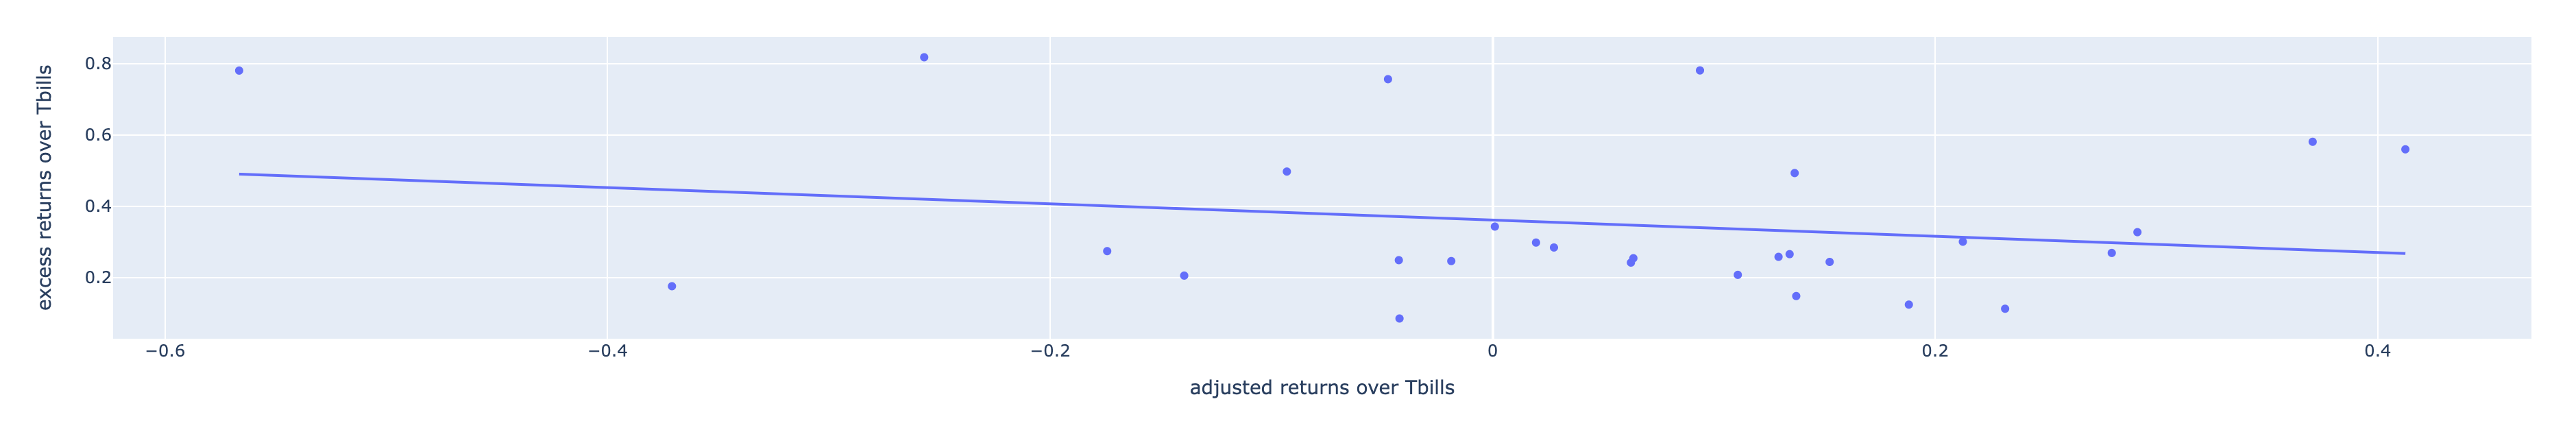

In [16]:
# plot:
alpha_fig = px.scatter(medallion_df, x='adjusted returns over Tbills', y='excess returns over Tbills', trendline='ols')
alpha_fig
Image(filename='./images/alpha.png', width=1700) 

#### Define alpha function and calculate:


In [12]:
# function:
def get_alpha(df, excess_returns, adjusted_returns):
    # set equation:
    alpha_formula = 'Q("' + excess_returns + '")'+ '~' + 'Q("' + adjusted_returns + '")'
    
    # fit the formula:
    model = smf.ols(formula=alpha_formula, data=df).fit()
    
    # get intercept:
    intercept = round(model.params[0], 2)
    
    return intercept

In [13]:
# calculate:
medallion_alpha = get_alpha(medallion_df, excess_returns='excess returns over Tbills', adjusted_returns='adjusted returns over Tbills')
medallion_alpha

0.36

**Note:** the Medallion fund's alpha of $0.36$ tell us that over the period of 30 years that the data spans, the fund's performance had an annual return that was $36\%$ better than expected!

---